In [ ]:
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision.models import MobileNet_V2_Weights
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
# from google.colab import drive

In [ ]:
# drive.mount('/content/gdrive')

In [ ]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

True
1
NVIDIA GeForce RTX 3060 Laptop GPU


In [ ]:
weights = MobileNet_V2_Weights.DEFAULT
model = models.mobilenet_v2(weights=weights)
torch.manual_seed(42)

train_transform = transforms.Compose([
    transforms.Resize(weights.transforms().crop_size),
    transforms.RandomRotation(10),                      
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),        
    transforms.RandomHorizontalFlip(p=0.5),
    weights.transforms()
])

test_transform = weights.transforms()

In [ ]:
base_dataset = datasets.ImageFolder('malaria_cells_nih')


g = torch.Generator().manual_seed(42)   
train_size = int(0.8 * len(base_dataset))
test_size  = len(base_dataset) - train_size
train_indices, test_indices = torch.utils.data.random_split(range(len(base_dataset)), [train_size, test_size], generator=g)
train_dataset = datasets.ImageFolder('malaria_cells_nih', transform=train_transform)
test_dataset  = datasets.ImageFolder('malaria_cells_nih', transform=test_transform)


In [ ]:
batch_size = 32
n_iters = 15000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=torch.utils.data.SubsetRandomSampler(train_indices.indices))

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, sampler=torch.utils.data.SubsetRandomSampler(test_indices.indices))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9124069..1.5981677].


Feature batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])


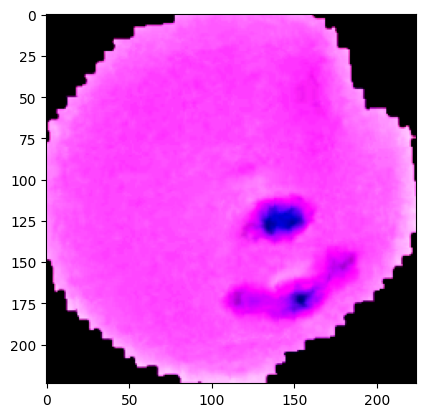

Label: 0 (Parasitized)


In [ ]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].permute(1, 2, 0)
label = train_labels[0]
plt.imshow(img.numpy())
plt.show()
statement = f"Label: {label} (Parasitized)" if label == 0 else f"Label: {label} (Uninfected)"
print(statement)

In [ ]:
print("=== FEATURES ===")
for i, layer in enumerate(model.features):
  print(i, ":", layer)
print("\n=== CLASSIFIER ===")
for i, layer in enumerate(model.classifier):
  print(i, ":", layer)

=== FEATURES ===
0 : Conv2dNormActivation(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU6(inplace=True)
)
1 : InvertedResidual(
  (conv): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
2 : InvertedResidual(
  (conv): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): Con

In [ ]:
for param in model.parameters():
  param.requires_grad = False

N = 5

for layer in model.features[-N:].parameters():
    layer.requires_grad = True

for param in model.classifier.parameters():
  param.requires_grad = True

trainable_params = [p for p in model.parameters() if p.requires_grad]

In [ ]:
print(model.classifier)

num_classes = 1
in_features = model.classifier[1].in_features

model.classifier[1] = nn.Linear(in_features=in_features, out_features=2, bias=True)

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)


In [ ]:
error = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(trainable_params, lr=1e-4, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=n_iters)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [16]:
count = 0
best_acc = 0
loss_list = []
iteration_list = []
accuracy_list = []
model.train()
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        train = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = model(train)
        loss = error(outputs, labels)
        loss.backward()
        optimizer.step()
        count += 1

        if count % 50 == 0:
            correct = 0
            total = 0

            model.eval()
            with torch.no_grad():
                for images, labels in test_loader:
                    test = images.to(device)
                    labels = labels.to(device)
                    outputs = model(test)
                    predicted = outputs.argmax(dim=1)
                    total += len(labels)
                    correct += (predicted == labels).sum()
            model.train()
            accuracy = 100 * correct / float(total)
            loss_list.append(loss.item())
            iteration_list.append(count)
            accuracy_list.append(accuracy)
            if accuracy > best_acc:
                best_acc = accuracy
                torch.save(model.state_dict(), "model2_best.pt")
        if count % 50 == 0:
            print(f"Iteration: {count}  Loss: {loss.item()} Accuracy: {accuracy}  %")
    scheduler.step()


Iteration: 50  Loss: 0.40558552742004395 Accuracy: 89.25979614257812  %
Iteration: 100  Loss: 0.32731157541275024 Accuracy: 94.04934692382812  %
Iteration: 150  Loss: 0.06729661673307419 Accuracy: 94.81131744384766  %
Iteration: 200  Loss: 0.09410221874713898 Accuracy: 94.95645904541016  %
Iteration: 250  Loss: 0.07990312576293945 Accuracy: 95.19230651855469  %
Iteration: 300  Loss: 0.11416053771972656 Accuracy: 95.26487731933594  %
Iteration: 350  Loss: 0.20749995112419128 Accuracy: 95.24673461914062  %
Iteration: 400  Loss: 0.16058768332004547 Accuracy: 95.46443939208984  %
Iteration: 450  Loss: 0.09951639175415039 Accuracy: 95.50072479248047  %
Iteration: 500  Loss: 0.33883196115493774 Accuracy: 95.48258209228516  %
Iteration: 550  Loss: 0.030415277928113937 Accuracy: 95.30116271972656  %
Iteration: 600  Loss: 0.04287319630384445 Accuracy: 95.60958099365234  %
Iteration: 650  Loss: 0.2639652490615845 Accuracy: 95.62772369384766  %
Iteration: 700  Loss: 0.32672223448753357 Accuracy: 

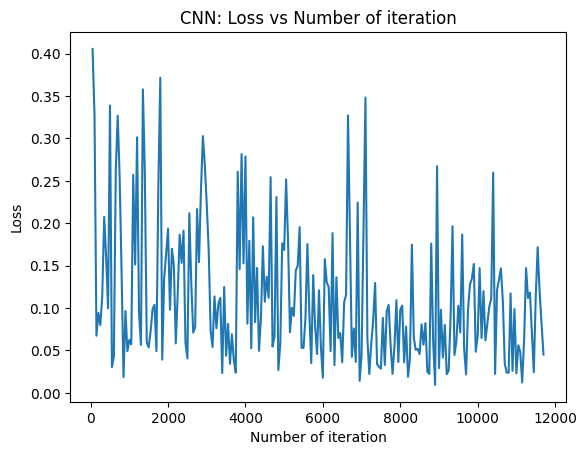

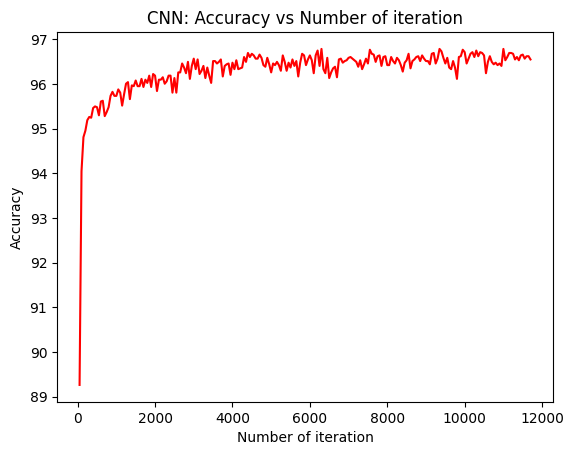

In [17]:
# visualization loss
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("CNN: Loss vs Number of iteration")
plt.show()

accuracy_list = [a.item() for a in accuracy_list]

# visualization accuracy
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Accuracy vs Number of iteration")
plt.show()

In [18]:
torch.save(model.state_dict(), "model2_state.pt")
torch.save(optimizer.state_dict(),"optim2_state.pt")


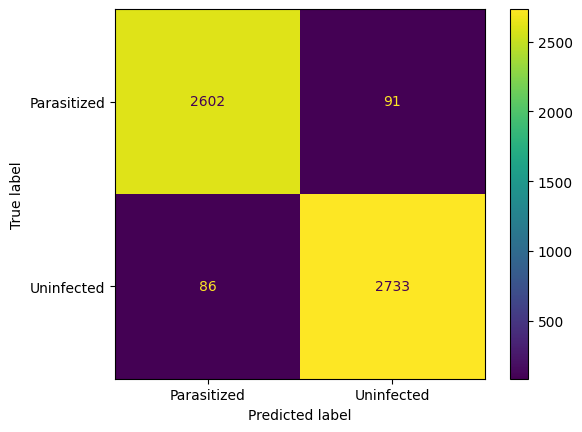

========= Parasitized as Positive Class =========
Total samples: 5512
Label counts: tensor([2693, 2819], device='cuda:0')
Pred counts : tensor([2688, 2824], device='cuda:0')
Correct: 5335 Wrong: 177
Accuracy from raw counts: 0.9678882438316401
precision: 0.9680059523773512  recall: 0.9662086891906194  f1: 0.9671064807797216  accuracy: 0.9678882438298841
TP, FP, FN, TN: 2602 86 91 2733

========= Uninfected as Positive Class =========
Total samples: 5512
Label counts: tensor([2693, 2819], device='cuda:0')
Pred counts : tensor([2688, 2824], device='cuda:0')
Correct: 5335 Wrong: 177
Accuracy from raw counts: 0.9678882438316401
precision: 0.9677762039625787  recall: 0.9694927279142622  f1: 0.9686337004723816  accuracy: 0.9678882438298841
TP, FP, FN, TN: 2733 91 86 2602


In [15]:
def print_binary_metrics(labels, preds, positive = 0):
    pos = positive
    neg = 1 - positive
    labels = labels.long()
    statement = "Parasitized as Positive Class" if positive == 0 else "Uninfected as Positive Class"
    print(f"========= {statement} =========")
    print("Total samples:", len(labels))


    print("Label counts:", torch.bincount(labels))
    print("Pred counts :", torch.bincount(preds))


    num_correct = (preds == labels).sum().item()
    num_total = len(labels)
    print("Correct:", num_correct, "Wrong:", num_total - num_correct)
    print("Accuracy from raw counts:", num_correct / num_total)
    
    tp = ((preds == pos) & (labels == pos)).sum().item()
    tn = ((preds == neg) & (labels == neg)).sum().item()
    fp = ((preds == pos) & (labels == neg)).sum().item()
    fn = ((preds == neg) & (labels == pos)).sum().item()

    eps = 1e-8  

    precision = tp / (tp + fp + eps)
    recall    = tp / (tp + fn + eps)
    f1        = 2 * precision * recall / (precision + recall + eps)
    accuracy  = (tp + tn) / (tp + tn + fp + fn + eps)
    print(f"precision: {precision}  recall: {recall}  f1: {f1}  accuracy: {accuracy}")
    print("TP, FP, FN, TN:", tp, fp, fn, tn)


state_dict = torch.load("model2_best.pt", weights_only=False)
model.load_state_dict(state_dict)
model.to(device)
model.eval()

all_labels = []
all_preds = []
with torch.no_grad():
    for images, labels in test_loader:
        test = images.to(device)
        labels = labels.to(device)
        outputs = model(test)
        predicted = outputs.argmax(dim=1)
        all_labels.append(labels)
        all_preds.append(predicted)

all_labels = torch.cat(all_labels)
all_preds = torch.cat(all_preds)



cm = confusion_matrix(all_labels.cpu(), all_preds.cpu())
class_names = ["Parasitized", "Uninfected"] 
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
cm_display.plot()
plt.show()

print_binary_metrics(labels=all_labels, preds=all_preds, positive=0)
print("")
print_binary_metrics(labels=all_labels, preds=all_preds, positive=1)


